## Trabajo Semanal 3 - BETTIG
### Simulación de un ADC (cuantización) parte 1/2

El objetivo de la tarea es simular el comportamiento de un ADC y cómo sus parámetros, tamaño de palabra de B bits y frecuencia de muestreo fs, afectan a una señal (aproximadamente) analógica.
Para ello se analizará una senoidal con los siguientes parámetros:
 - Frecuencia f_0 = f_s/N = Δf
 - Amplitud normalizada, es decir, unitaria

<br> Se diseñará un bloque cuantizador que opere sobre una señal discreta en tiempo Sr, de forma tal que para un ADC de B bits y rango ±VF, el operador $ S_Q = Q_{B,V_F} [S_R] $ generará una Sq comprendida entre ±VF y con valores discretos establecidos por el paso de cuantización $q = \frac{V_F}{2^{B-1}}$

<br> Una vez realizado esto último, se obtendra el ruido de cuantificación y se analizarán los estadísticos de la misma

### Desarrollo del Trabajo

Primero que nada, voy a incluir las bibliotecas necesarias para el desarrollo de la tarea

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.signal as sig

Luego, presentaré todas las funciones para el desarrollo de la misma, algunas ya fueron previamente utilizadas en tareas anteriores:

In [2]:
def sin_gen(vmax = 1, dc = 0, ff = 1, ph = 0, nn = 1000, fs = 1000):
    # Lo primero que hay que hacer es crear un vector temporal que determinará
    # el inicio y el fin de la señal
    ts = 1/fs   # Tiempos de muestreo, intervalo de tiempo en el que se  
                # tomarán las muestras
    tf = nn * ts # Tiempo final de la señal
    tt = np.arange(0, tf, ts) # Creo el vector temporal
    ##
    # Ahora tengo que generar mi señal senoidal, para eso voy a aprovechar
    # la función np.sin de la biblioteca numpy. Para ello, debemo evaluar
    # dicha función en cada uno de los puntos del vector temporal creado
    # previamente
    xx = vmax * np.sin(2 * np.pi * ff * tt + ph) + dc
    ##
    # Devuelvo el vector temporal y el valor de la señal en cada uno de esos
    # puntos
    return tt, xx

# Sabemos que la varianza de una función aleatoria con distribución
# uniforme puede ser calculada como Var(X) = q²/12
def rnd_nmbrs_gen(var, N):
    q = math.sqrt(var*12);
    rnd_numbers = q * np.random.random(N) - (q/2);
    return rnd_numbers;

# El objetivo de la función es obtener una señal aleatoria a partir de una
# relación señal a ruido definida por parámetro, considerando como señal
# una senoidal de amplitud normalizada ( sqrt(2) ) 
def noise_gen(snr, N):
    # Lo primero que tenemos que hacer es obtener la varianza de la señal
    # aleatoria, tengamos en cuenta que esto está normalizado, por lo que
    # luego habría que desnormalizar
    var = np.power(10.0,snr/(-10.0));
    return rnd_nmbrs_gen(var, N);

Ahora voy a definir cuales son los parámetros de mi ADC simulado. Estos serán la tensión de referencia y la cantidad de bits. Para empezar, voy a comenzar utilizando un ADC de 4 bits

In [3]:
Vr = 2;                         # Tensión de referencia del ADC
n_bits = 4;                     # Cantidad de bits del ADC
quantum = Vr / (2**(n_bits-1)); # Calculo el valor del cuanto (Cada paso del ADC)

Luego, definiré los parámetros de mi función "analógica". A modo de ejercicio, le agregaré ruido montado en la señal senoidal con una SNR también definida por parámetro. El objetivo de esto es que la practica se asemeje un poco mas alo que ocurriría en la realidad

In [4]:
# Con esta frecuencia representaré la señal analógica 

f_cont  = 500 # Frecuencia de muestreo
N       = 100 # Cantidad de muestras

# Establezco la frecuencia de mi señal senoidal, la relación señal a ruido
# que tendrá y la amplitud de la misma (En este caso, unitaria)

f_sin   = 10; # Frecuencia de mi senoidal
snr     = 20; # Relación señal a ruido
A_sin   = 1;  # Amplitud de Senoidal

Obtendré las señales en cuestión: mi senoidal, el ruido y la señal final con la que luego trabajaré. En este caso, mi generador de ruido devuelve una señal con distribución uniforme y calculada para una señal senoidal de potencia unitaria (A = $\sqrt{2}$), por lo que debo desnormalizarla para poder utilizarla

In [5]:
t, y_sin = sin_gen(A_sin, 0, f_sin, 0, N, f_cont)
y_noise = (A_sin/(math.sqrt(2))) * noise_gen(snr, N);
noisy_sin = y_sin + y_noise;

Voy a presentar estas 3 señales para poder observarlas:

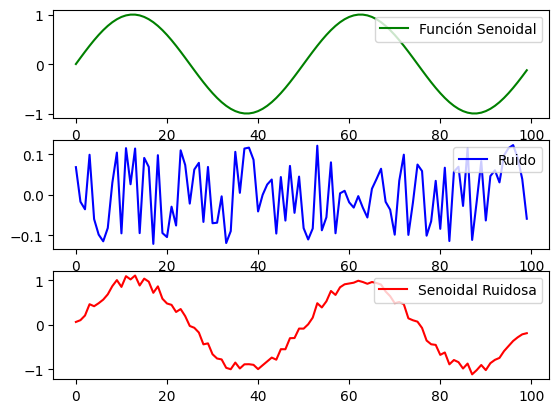

In [6]:
fig1, (ax1, ax2, ax3) = plt.subplots(3);

# Lo primero que voy a hacer es generarme la señal senoidal 
# sin_gen(Amp, DC, Frec, Phase, Muestras, Fs)
ax1.plot(y_sin, color = 'green', label = 'Función Senoidal')
ax1.legend(loc = 'upper right');

# Luego voy a generar la señal aleatoria, donde el primero parámetro
# será la relación señal a ruido deseada y el segundo parámetro la 
# cantidad de muestras
ax2.plot(y_noise, color = 'blue', label = 'Ruido')
ax2.legend(loc = 'upper right');

# Por último, voy a desnormalizar y realizar la suma de ambas
ax3.plot(noisy_sin, color = 'red', label = 'Senoidal Ruidosa')
ax3.legend(loc = 'upper right');


Lo próximo que haré será el muestreo seguido de la cuantización de la señal. Para el primero, lo que haré es quedarme con una muestra cada N muestras de mi señal de trabajo (decimación). Por otro lado, voy a tomar cada punto de mi señal muestreada, lo redondearé y lo multiplicaré por la mínima cuenta del ADC (La cual dependerá del número de bits y la tensión de referencia). Para finalizar, obtendré el ruido de cunatificación como la diferencia entre mi señal muestreada y la señal cuantizada

In [7]:
# Lo que voy a hacer ahora, para simular un muestreador, es quedarme con
# una muestra cada "ovs_rate" muestras.
ovs_rate = 2;
noisy_sin_sampled = noisy_sin[::ovs_rate]
# Luego voy a realizar la cuantificación, para ello voy a generar el redondeo
# de cada una de las muestras y luego multiplicarlas por el cuanto
noisy_sin_quantif = np.round(noisy_sin_sampled/quantum, decimals = 0) * quantum;
# Por útlimo, voy a obtener el ruido de cuantificación haciendo la resta entre
# la señal original y la señal cuantizada
quantif_noise = noisy_sin_sampled - noisy_sin_quantif;

Los resultados son los siguientes:

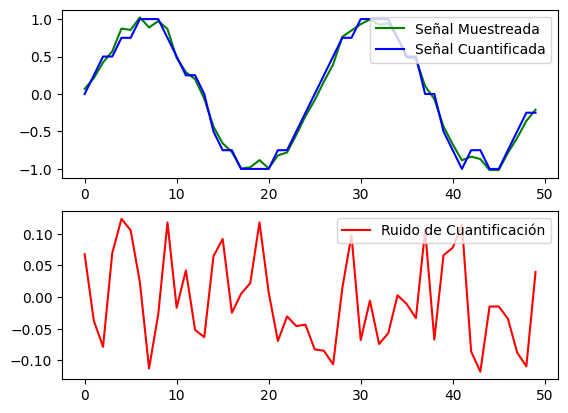

In [8]:
fig2, (ax1, ax2) = plt.subplots(2);

ax1.plot(noisy_sin_sampled, color = 'green', label = 'Señal Muestreada')
ax1.legend(loc = 'upper right');
ax1.plot(noisy_sin_quantif, color = 'blue', label = 'Señal Cuantificada')
ax1.legend(loc = 'upper right');
ax2.plot(quantif_noise, color = 'red', label = 'Ruido de Cuantificación')
ax2.legend(loc = 'upper right');

Se observa como existe una diferencia entre la señal muestreada y la cuantizada, esto es justamente el ruido de cuantización (señal roja).
<br> Observemos ahora que pasa al aumentar la cantidad de bits que posee el ADC

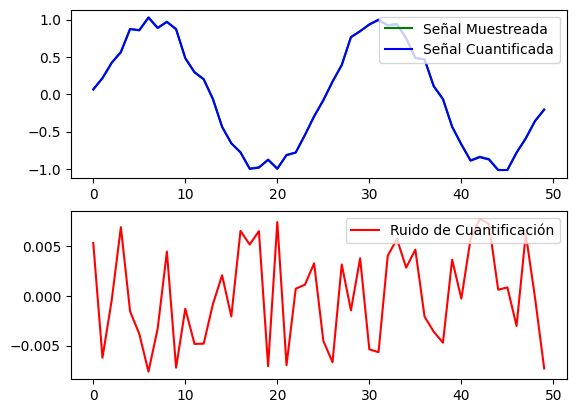

In [9]:
Vr = 2;                         # Tensión de referencia del ADC
n_bits = 8;                     # Cantidad de bits del ADC
quantum = Vr / (2**(n_bits-1)); # Calculo el valor del cuanto (Cada paso del ADC)

# Lo que voy a hacer ahora, para simular un muestreador, es quedarme con
# una muestra cada "ovs_rate" muestras.
ovs_rate = 2;
noisy_sin_sampled = noisy_sin[::ovs_rate]
# Luego voy a realizar la cuantificación, para ello voy a generar el redondeo
# de cada una de las muestras y luego multiplicarlas por el cuanto
noisy_sin_quantif = np.round(noisy_sin_sampled/quantum, decimals = 0) * quantum;
# Por útlimo, voy a obtener el ruido de cuantificación haciendo la resta entre
# la señal original y la señal cuantizada
quantif_noise = noisy_sin_sampled - noisy_sin_quantif;

fig2, (ax1, ax2) = plt.subplots(2);

ax1.plot(noisy_sin_sampled, color = 'green', label = 'Señal Muestreada')
ax1.legend(loc = 'upper right');
ax1.plot(noisy_sin_quantif, color = 'blue', label = 'Señal Cuantificada')
ax1.legend(loc = 'upper right');
ax2.plot(quantif_noise, color = 'red', label = 'Ruido de Cuantificación')
ax2.legend(loc = 'upper right');

A simple vista, para un B = 8, la señal muestreada es prácticamente igual a la señal cuantizada. A modo de ejemplo, se hará lo mismo pero para B = 12:

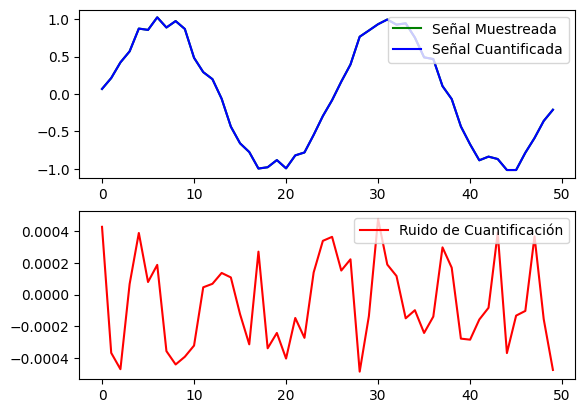

In [10]:
Vr = 2;                         # Tensión de referencia del ADC
n_bits = 12;                    # Cantidad de bits del ADC
quantum = Vr / (2**(n_bits-1)); # Calculo el valor del cuanto (Cada paso del ADC)

# Lo que voy a hacer ahora, para simular un muestreador, es quedarme con
# una muestra cada "ovs_rate" muestras.
ovs_rate = 2;
noisy_sin_sampled = noisy_sin[::ovs_rate]
# Luego voy a realizar la cuantificación, para ello voy a generar el redondeo
# de cada una de las muestras y luego multiplicarlas por el cuanto
noisy_sin_quantif = np.round(noisy_sin_sampled/quantum, decimals = 0) * quantum;
# Por útlimo, voy a obtener el ruido de cuantificación haciendo la resta entre
# la señal original y la señal cuantizada
quantif_noise = noisy_sin_sampled - noisy_sin_quantif;

fig2, (ax1, ax2) = plt.subplots(2);

ax1.plot(noisy_sin_sampled, color = 'green', label = 'Señal Muestreada')
ax1.legend(loc = 'upper right');
ax1.plot(noisy_sin_quantif, color = 'blue', label = 'Señal Cuantificada')
ax1.legend(loc = 'upper right');
ax2.plot(quantif_noise, color = 'red', label = 'Ruido de Cuantificación')
ax2.legend(loc = 'upper right');

Conclusión, a medida que aumentamos la cantidad de bits en nuestro ADC disminuirá el ruido de cuantificación. La desventaja de esto es que el ADC comenzará a ser cada vez mas costoso. Por otro lado, hay que tener en cuenta que al aumentar el número de bits, los simbolos cercanos al cero estarán estar ocultos por el ruido (Es por ello que existe el concepto de ENOB)

Voy a aprovechar esta última simulación para estudiar algunas características de la señal de ruido. Sabemos que es una señal estocástica por lo que no tendrá una ley que la rija. Por lo tanto, los parámetros que nos interesan de la misma son sus "estocásticos", entre ellos su valor medio y varianza.

<br> Primero que nada, el ruido será mostrado normalizado entre Q/2 y -Q/2 para que su representación sea un poco mas amena. Por otro lado, podremos obtener un aproxiamdo de la distribución si imprimimos un histograma de la señal. Lo que hacemos con esto es observar "cuantas veces" ocurrió una determinado cuanto. Si todo es correcto, debería asemejarse a la uniformidad, ya que cada cuanto tiene la misma probabilidad de ocurrir.

El valor medio es: -4.914096419203623e-05 el cual debería ser cercano a cero
La varianza obtenida de suponer una distribución uniforme es: 7.947285970052083e-08
La varianza obtenida a partir de la expresión de numpyy es: 7.594578775024026e-08
La varianza obtenida a partir de suponer un ruido totalmente incorrelacionado es 7.836062211196324e-08


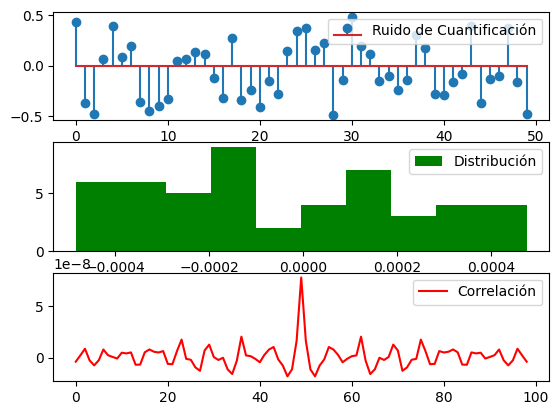

In [11]:
# Obtengo el valor medio del ruido de cuantificación, el cual debería 
# ser cero
mean_quantif_noise = np.mean(quantif_noise);

# Tengo tres formas distintas de obtener la varianza del ruido: La primera
# de ellas se obtiene de suponer una distribución uniforme del mismo, la 
# segunda es a través de la herramienta de cálculo que proporciona numpy,
# y la última, se obtiene de la autocorrelación de la señal. Esta última se
# cumplirá unicamente si el ruido está totalmente incorrelacionado, obteniendo
# un delta de kronecker en el origen (representando la energía de la señal)
var_quantif_noise_1 = (np.float64(quantum)**2)/12
var_quantif_noise_2 = np.var(quantif_noise)
var_quantif_noise_3 = sig.correlate(quantif_noise, quantif_noise)/(N/ovs_rate)

fig3, (ax1, ax2, ax3) = plt.subplots(3);

# Voy a imprimir el ruido de cuantización normalizado en quantum, esto me 
# fijará el límite superior en quantum/2 y el inferior en -quantum/2
ax1.stem(quantif_noise/quantum, label = 'Ruido de Cuantificación')
ax1.legend(loc = 'upper right');

# Por otro lado, voy a imprimir la distribución, que se todo salió acorde 
# a la teoría, debería ser uniforme
ax2.hist(quantif_noise, color = 'green', label = 'Distribución');
ax2.legend(loc = 'upper right');

# Por último, voy a imprimir los resultados de la autocorrelación de la señal
# Si todo es correcto, debería haber una delta en el origen cuya amplitud
# es igual a la varianza del ruido
ax3.plot(var_quantif_noise_3, color = 'red', label = 'Correlación');
ax3.legend(loc = 'upper right');

print("El valor medio es:",mean_quantif_noise,"el cual debería ser cercano a cero")
print("La varianza obtenida de suponer una distribución uniforme es:", var_quantif_noise_1)
print("La varianza obtenida a partir de la expresión de numpyy es:", var_quantif_noise_2)
print("La varianza obtenida a partir de suponer un ruido totalmente incorrelacionado es", max(var_quantif_noise_3))

 - El valor medio obtenido es prácticamente nulo (Existe un error númerico al realizar el cálculo) 
 - Se calculó la varianza de 3 formas distintas y en todos los casos se obtuvo un resultado similar, indicando, por un lado, que la señal tendrá una distribución uniforme y a su vez, estará totalmente incorrelacionada. Esto último se puede observar en el gráfico de la correlación, donde tenemos una delta de Kronecker en el origen indicando que existirá una similitud entre muestras unicaménte cuando la señal con su conjugada se encuentren solapadas, es decir, desplazamiento nulo (pensando en el cálculo de la autocorrelación). 